# Organizing, Subsetting and Processing Data

Now that you've successfully downloaded the GRACE and GLDAS data, you will need to read in and process the data to get groundwater anamoly estimates. Both datasets have raw data contained in .nc or .nc4 files. These are files for storing multi-dimensional data--in our case, the key dimensions we are interested in are latittude and longitude (geography) and time. We can use the `xarray` package to read in these data. 

## Reading in GRACE and GLDAS Data

Both datasets have similar processes for loading in the data which are outlined in detail below. However, the first step for processing both datasets is to filter to your region of interest. This is important because it makes processing times for each step much quicker. As such, our first step in processing will be loading in a shapefile and filtering to the region of interest before loading in GRACE and GLDAS and merging them with other datasets. 

### Subsetting The Data 

For most use cases, it will make the most sense to load in a shapefile and use this file to narrow down your region. This will allow your analysis to focus on your area of interest as precisely as possible and improve the efficiency of your code. If you don't have a shapefile or know your region of interest, you can pick any 4 latitude/longitude points and use them to draw a rectangle around a region of the world you are interested in. You can also skip this step, but note it will make the code take much longer to run. 

For our analysis here, we will use a shapefile that focuses on the Colorado River Basin. 

#### What is a Shapefile? 

A shapefile is a file that stores geometric location and attribute information of geographical features in a nontopological way. Shapefiles represent geographical features by points, lines, or polygons (geographical areas) (ArcGIS). It is one of the simpler ways to store and work with geographic data. Many shapefiles are publicly available for download by government agencies, researchers, or practitioners. Below is an example of what a shapefile looks like in tabular form and how you can go from that to a map.

<img src='images/shape%20file%20figure.png'>
Source: ReStore

#### Applying This Method to the CRB 

Below, we use this method to use a shapefile of the Colorado River Basin for analysis. You can download the shape file for the Colorado River Basin from ArcGIS hub [here](https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/colorado-river-basin-hydrological-boundaries-with-areas-served-by-colorado-river/explore?location=36.244092%2C-110.573590%2C6.00). A visual of this is shown below: 

<img src='images/CRB_shapefile.png'>

To work with shapefiles, we will use the `geopandas` package, a spatial analysis package built on top of `pandas`. We will begin by loading in this package and reading in the shapefile. Next, we will load in plotting functions from `matplotlib` and map the shapefile. 

<Figure size 1000x1000 with 0 Axes>

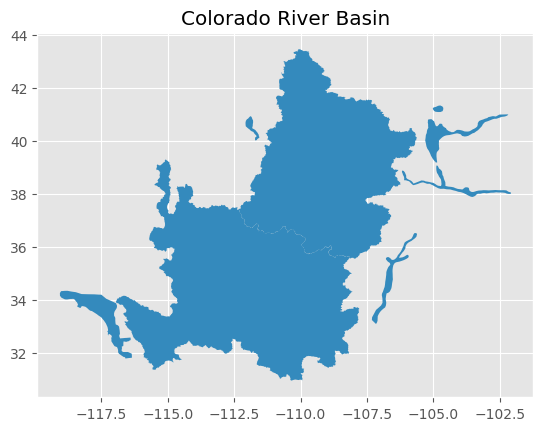

In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt

shpfl = gpd.read_file("/home/kmk58/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")

# plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
shpfl.plot()
plt.title("Colorado River Basin")
plt.grid(which="minor")
#plt.minorticks_on()
plt.show()

A simple way to start narrowing down to the area within the Colorado River Basin is to construct a rectangle around the region and only read in and process rows within that rectangle: 

<p align="left">
    <img src="images/CRB%20rectangle.jpg" width="600" />
</p>

As you can see from the image above, a substantial amount of geography that is not within the CRB is still in the rectange. We will use spatial processes to eliminate those from our dataset later in the process. For now though, focusing on this rectangle will greatly speed up reading and applying other transformations to the data. 

The code to do this is provided below. 

In [2]:
# Code to filter to shapefile

# extract a dataframe of the coordinates from the shapefile
coords = shpfl.get_coordinates()
# find the maximum and minimum lat/longs, corresponding to the red points on the figure above
lon_min = min(coords['x'])
lon_max = max(coords['x'])
lat_min = min(coords['y'])
lat_max = max(coords['y'])

### GRACE

The GRACE MASCON data is contained in 1 .nc file and contains global land MASCON GRACE data. We start by using `xarray` to read in the data. 

In [3]:
import xarray as xr
import os

os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [4]:
# Need to change this to relative path later
grace = xr.open_dataset("/home/kmk58/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

# print out grace data 
grace

/home/kmk58/.local/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 220, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2023-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-06-28T21:06:45Z

The first thing you will note is that the dataset has several dimensions: `lon`, `lat`, `time`, and `bounds`. This is because the GRACE data come at the pixel-level for each year. In our sitution, a pixel is the smallest geographic unit of analysis. Because collecting and processing GRACE satellite data is technical and compuationally expensive, GRACE measurements are given as .5-degree by .5-degree squares. The pixels cover the entire Earth's surface and each have a GRACE measurement monthly from 2002-present. A visual of this is shown below, where each square in the GRID correponds to a pixel (Sharma, Patnaik, Biswal, Reager, 2020). Note that the yellow dots are gauging stations for comparison. 

<p align="center">
    <img src="images/GRACE_grids.png" width="500" />
</p>

First, since the data is an xarray dataset, we can do some processing to transform the dataset into a standard tabular, pandas dataframe. For efficiency, we can also only select the variables we need, and for use with other datasets, we will transform the longitude points from a [0,360] range to a [-180,180] range.  

An **important** point to note is that when we change our data into a tabular format, each latitude and longitude combination will be the center of a pixel and will uniquely identify each pixel. Thus, it is important to understand that the associated value is not representative of this exact point but rather the entire pixel that the point is a center of. Though not necessary for our analysis, if you wanted to get the coordinates of each of the four corners, you would just have to add and subtract the pixel length divided by 2 to each latitude and longitude value. 

In [5]:
# transforming to dataframe and selecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df = grace_df.drop_duplicates()

In [6]:
# transforming to dataframe and selecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)
grace_df.reset_index(drop=True)
grace_df = grace_df.drop_duplicates()

#subsetting to rectangle containing the Colorado River Basin
grace_df["lon"] = grace_df["lon"] - 180  # converting longitude points

grace_df = grace_df[(grace_df.lon> lon_min) & (grace_df.lon < lon_max)]
grace_df = grace_df[(grace_df.lat> lat_min) & (grace_df.lat < lat_max)]

grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936
9715641,-118.75,31.25,2002-05-10 12:00:00,1.167702,2.103443,1.603936
9715642,-118.75,31.25,2002-08-16 12:00:00,1.007997,1.662054,1.603936
9715643,-118.75,31.25,2002-09-16 00:00:00,0.214690,2.150112,1.603936
9715644,-118.75,31.25,2002-10-16 12:00:00,0.542129,1.425143,1.603936
...,...,...,...,...,...,...
12334735,-102.25,43.25,2022-12-16 12:00:00,-8.107416,1.184209,2.189324
12334736,-102.25,43.25,2023-01-16 12:00:00,-7.207149,1.448307,2.189324
12334737,-102.25,43.25,2023-02-15 00:00:00,-6.630485,1.746566,2.189324
12334738,-102.25,43.25,2023-03-16 12:00:00,-7.038567,2.052503,2.189324


The last step in processing GRACE data is to multiply each pixel by a scale factor. These values are intended to restore much of the energy that is removed due the sampling and post-processing of GRACE observations. More information about the scaling factors can be found [here](https://grace.jpl.nasa.gov/data/get-data/monthly-mass-grids-land/). Moreover, please note that NASA states users should multiply the data by the scaling coefficient, so it is imperative not to skip this step. 

In [7]:
grace_df.sort_values(by='time', inplace=True)
grace_df['new_lwe'] = grace_df['lwe_thickness'] * grace_df['scale_factor']
grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor,new_lwe
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936,1.821861
11458480,-107.75,32.25,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458700,-107.75,32.75,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458920,-107.75,33.25,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
11459140,-107.75,33.75,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
...,...,...,...,...,...,...,...
11460019,-107.75,35.25,2023-04-16 00:00:00,-6.318313,8.447631,1.251672,-7.908456
11459799,-107.75,34.75,2023-04-16 00:00:00,-6.318313,8.447631,0.990343,-6.257299
11459579,-107.75,34.25,2023-04-16 00:00:00,-21.944085,6.949303,1.469034,-32.236599
11538559,-107.25,33.75,2023-04-16 00:00:00,-21.944085,6.949303,0.682281,-14.972040


### GLDAS Data 

Next, we will read in the GLDAS data which provides us with information on snow pack and soil moisture. These data are similarly in a multidimensional data format which can be read in using `xarray`. However, the data come in individual files that require being read in and combined into one dataset. The code below does this. 

In [8]:
### import GLDAS data, filter to CRB, combine into one dataframe 

import pandas as pd

gl_path = "/home/kmk58/remoteData/GLDAS/NOAH_monthly_L4/"

gl_df = pd.DataFrame()
itera = 0

#Iterating through files in path
for filename in os.listdir(gl_path):
    
    if filename.endswith(".nc4"):
        
        #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(gl_path+str(filename))
        xd_df = xd.to_dataframe()

        xd_df.reset_index(inplace=True)

        xd_df = xd_df[(xd_df.lon> lon_min) & (xd_df.lon < lon_max)]
        xd_df = xd_df[(xd_df.lat> lat_min) & (xd_df.lat < lat_max)]

        #Extracting only needed columns 
        df_slice = xd_df[["time", "lon", "lat", "SWE_inst", 'SoilMoi0_10cm_inst',
           'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst', 'SoilMoi100_200cm_inst', 'RootMoist_inst']]
        df_slice = df_slice.drop_duplicates()

        gl_df = pd.concat([gl_df, df_slice], axis=0)
        itera+=1

### Focusing on the Basin 

Returning to the GRACE data, we saw earlier that though the data is filtered down to a rectangle containing the Colorado River Basin, there are still areas that are not contained in the rectangle. We can use geoprocessing techniques from `geopandas` to keep points in GRACE that only intersect the shape file. 

In [10]:
shpfl = shpfl.set_crs('epsg:4326')

In [11]:
# create a geodataframe of lat/longs from the grace data
gdf = grace_df[["lon","lat"]].drop_duplicates()

gdf_points = gpd.GeoDataFrame(gdf, 
                              crs='epsg:4326',
                              geometry=gpd.points_from_xy(gdf['lon'],
                                                          gdf['lat']))

# filter to the points that intersect the shapefile
#grace_shp_df = pd.DataFrame()
#itera = 0
gdf_points = gdf_points.merge(grace_df, how="inner", on = ['lon','lat'])
#s = shpfl.to_crs(gdf_points.crs)
grace_shp_df = gpd.sjoin(gdf_points, shpfl, how='inner', op='intersects')



"""
for sh in shpfl["geometry"]:
    temp_df = grace_df[gdf_points.intersects(sh)]
    grace_shp_df = pd.concat([grace_shp_df,temp_df])
    
    itera+=1
"""

/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


'\nfor sh in shpfl["geometry"]:\n    temp_df = grace_df[gdf_points.intersects(sh)]\n    grace_shp_df = pd.concat([grace_shp_df,temp_df])\n    \n    itera+=1\n'

In [12]:
grace_shp_df

,lon,lat,geometry,time,lwe_thickness,uncertainty,scale_factor,new_lwe,index_right,OBJECTID,Shape__Are,Shape__Len,COUNT2,HU_6_Name
2200,-107.75,36.25,POINT (-107.75000 36.25000),2002-04-17 12:00:00,1.351319,13.096065,0.653928,0.883666,7,8,4.720553e+11,5.263212e+06,NaN,Upper Colorado
2201,-107.75,36.25,POINT (-107.75000 36.25000),2002-05-10 12:00:00,12.154783,7.273748,0.653928,7.948355,7,8,4.720553e+11,5.263212e+06,NaN,Upper Colorado
2202,-107.75,36.25,POINT (-107.75000 36.25000),2002-08-16 12:00:00,-17.411682,5.499419,0.653928,-11.385990,7,8,4.720553e+11,5.263212e+06,NaN,Upper Colorado
2203,-107.75,36.25,POINT (-107.75000 36.25000),2002-09-16 00:00:00,-16.526976,7.196034,0.653928,-10.807456,7,8,4.720553e+11,5.263212e+06,NaN,Upper Colorado
2204,-107.75,36.25,POINT (-107.75000 36.25000),2002-10-16 12:00:00,-24.470710,4.377036,0.653928,-16.002087,7,8,4.720553e+11,5.263212e+06,NaN,Upper Colorado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119235,-117.25,33.75,POINT (-117.25000 33.75000),2022-12-16 12:00:00,-19.125283,1.468784,1.802905,-34.481066,5,6,2.534281e+10,1.220108e+06,NaN,Colorado River Aqueduct Service Area
119236,-117.25,33.75,POINT (-117.25000 33.75000),2023-01-16 12:00:00,-17.598774,1.905158,1.802905,-31.728916,5,6,2.534281e+10,1.220108e+06,NaN,Colorado River Aqueduct Service Area
119237,-117.25,33.75,POINT (-117.25000 33.75000),2023-02-15 00:00:00,-15.706288,2.379065,1.802905,-28.316944,5,6,2.534281e+10,1.220108e+06,NaN,Colorado River Aqueduct Service Area
119238,-117.25,33.75,POINT (-117.25000 33.75000),2023-03-16 12:00:00,-15.985284,2.861529,1.802905,-28.819946,5,6,2.534281e+10,1.220108e+06,NaN,Colorado River Aqueduct Service Area


In [13]:
test

NameError: name 'test' is not defined

##### Upsampling GRACE

One key consideration for combining GRACE and GLDAS data is that pixels in GRACE data are .5°x.5° while GLDAS data has .25°x.25° pixels. One way to handle this without loss of data is to "upscale" GRACE data to make it mergable with GLDAS. That is, transform the GRACE data pixels from .5°x.5° to .25°x.25°. That is, we transform the GRACE data pixels from a granularity of .5°x.5° to one of .25°x.25°. This process yields a four points for each original point.

One way we can do this is to "upsample" GRACE data. This is shown visually below: 

<p align="center">
    <img src="images/upscale.png" width="500" />
</p>

 After "upsampling" the GRACE data, it now also has a .25° by .25° granularity. Each "pixel" thus represents a chunk of land approximately 235.46 miles squared ($\approx$ 378.94 kilometers squared). A visualization of an individual pixel is shown below.

<p align="center">
    <img src="images/lon-lat.png" width="500" />
</p>

In [14]:
import collections
import pandas as pd

#create an empty dataframe that will store your upsampled points
up_gr_df = pd.DataFrame()

#iterating through each point in time (months)
for t in collections.Counter(grace_shp_df["time"]).keys():
    
    #for each time point, subset the dataframe to contain only data points corresponding only to that date
    sub_df_gr = grace_shp_df[grace_shp_df["time"] == t]
    
    # iterate through each 0.5 granularity longitude and latitude 
    for x,y in zip(sub_df_gr["lon"], sub_df_gr["lat"]):
        
        #subset the dataframe to contain only data points corresponding 
        #to a specific 0.5 granularity longitude/latitude pair
        val_df = sub_df_gr[(sub_df_gr["lon"]==x)&(sub_df_gr["lat"]==y)]
                
        #create upscaled longitude values (by creating a distance of 0.125 on each side of the
        #original longitude (x), you obtain a total length of 0.25 around each original point)
        xx = [round(x-0.125,3), round(x+0.125,3)] 
        
        #create upscaled latitude values (by creating a distance of 0.125 on each side of the
        #original latitude (y), you obtain a total length of 0.25 around each original point)
        yy = [round(y-0.125,3), round(y+0.125,3)]
        
        #create new dataset to containing upsampled points for specific longitude/latitude pair
        temp_df = pd.DataFrame()
        
        #time remains the same
        temp_df["time"] = [t]*4
        
        #creating four new points (longitude/latitude pairs on 0.25 granularity scale)
        #new points: 
        #(x-0.125,y-0.125)
        #(x-0.125,y+0.125)
        #(x+0.125,y-0.125)
        #(x+0.125,y+0.125)
        temp_df["lon"] = [xx[0],xx[0],xx[1],xx[1]]
        temp_df["lat"] = [yy[0],yy[1],yy[0],yy[1]]
        
        #assigning upscaled datapoints the same value as the original longitude/latitude point
        temp_df["lwe_thickness"] = [val_df["lwe_thickness"].mean()]*4

        #adding new information to the upscaled point dataframe
        up_gr_df = pd.concat([up_gr_df,temp_df])

#### Edge Pixels

The edges of the basin often do not completely intersect with a pixel. For example, in the figure below, each square on the graph is a 5°x.5° square. As you can see, within the center of the basin, there is perfect overlap between several pixels and the basin. However, when you get to the outer edges of the basin, you can see that there is not perfect overlap with a pixel. The basin only covers part of a pixel around the edges. 

For our analysis, we only include a pixel in calculating groundwater anamolies if the center of the pixel is contained within the basin. This will generally include pixels that have a majority of their area within the basin and exclude pixels that do not. Additionally, since the Colorado River Basin is so large, the effect of edge cases on our calculations will be small. However, if you plan to analyze the region within a smaller basin, one strategy to account for this is to use an area weighting average of the pixel with the basin. This will allow you to weight your values by the area that intersects both the pixel and the basin. 

<Figure size 1000x1000 with 0 Axes>

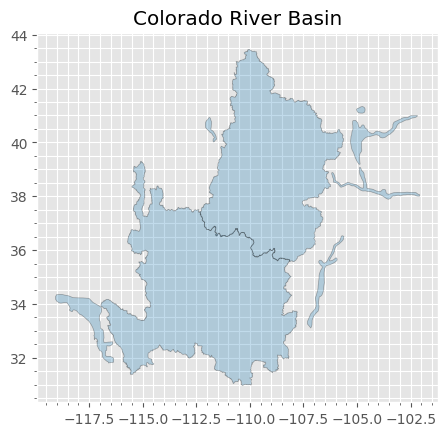

In [15]:
# plot of entire Colorado River Basin
plt.style.use('ggplot')
plt.figure(figsize=[10,10])
shpfl.plot(alpha=.3, edgecolors='black')
plt.title("Colorado River Basin")
plt.grid(which="minor")
plt.minorticks_on()
plt.show()

### Merging the Datasets 

Now that GRACE and GLDAS are in standardized, tabular formats, we can merge these datasets together to combine all the variables of interest and calculate groundwater estimates. Note that since the GRACE data is already filtered to the area of interest, we can simply perform a left join to merge GLDAS with GRACE data. 

In [61]:
# standardize times in both datasets and do a left join 
from datetime import datetime

up_gr_df['time'] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in up_gr_df["time"]]
gl_df["time"] = [datetime.strptime(str(t)[0:7], '%Y-%m') for t in gl_df["time"]]

gw_final_df = up_gr_df.merge(gl_df, on=["time", "lat", "lon"], how="left")

### Generating Groundwater Anamolies 

In order to compute groundwater anamolies, you need to compute the deviation from the mean for each measurement:

$d_i = p_i - \mu$ 

where ($d_i$) is the deviation from the mean for obervation i, ($p_i$) is the measurement for observation i, and $\mu$ is the average over the specified time period. 

In order to calculate $\mu$, you take the average for each water category over a specified time period. Here, we use the time period from 2004-2009, following NASA and recent literature, which is shown in code below. Note that the code is easily modifiable if you would like to focus on a different time period. 


In [62]:
# generate baseline sequence of dates
from datetime import timedelta

start_date = datetime.strptime("2004-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2009-12-01", "%Y-%m-%d")

base_line_dates = pd.date_range(start_date, end_date,freq='M',unit="s")
base_line_dates = base_line_dates + timedelta(days=1)

In [63]:
#generate baseline means for each water type 

baseline_df = gw_final_df[gw_final_df['time'].isin(base_line_dates)]
baseline_df['lon/lat']=baseline_df['lat'].astype(str) + baseline_df['lon'].astype(str) 
baseline_df=baseline_df[['lat','lon','lon/lat','lwe_thickness', 'SWE_inst', "RootMoist_inst"]].drop_duplicates()

pixel_avgs = baseline_df.groupby(['lon/lat']).mean().reset_index()
pixel_avgs['lwe_mean']=pixel_avgs['lwe_thickness']
pixel_avgs['swe_mean']=pixel_avgs['SWE_inst']
pixel_avgs['soil_mean']=pixel_avgs['RootMoist_inst']
pixel_avgs=pixel_avgs[['lat','lon','lon/lat','lwe_mean', 'swe_mean', 'soil_mean']]
pixel_avgs
#swe_mean = baseline_df['SWE_inst'].mean()
#sm_mean = baseline_df['RootMoist_inst'].mean()


/tmp/ipykernel_1485014/2538955779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df['lon/lat']=baseline_df['lat'].astype(str) + baseline_df['lon'].astype(str)


,lat,lon,lon/lat,lwe_mean,swe_mean,soil_mean
0,31.125,-110.125,31.125-110.125,0.073550,0.001962,15.633802
1,31.125,-110.375,31.125-110.375,0.073550,0.002201,16.488115
2,31.125,-110.625,31.125-110.625,0.073550,0.001179,16.570145
3,31.125,-110.875,31.125-110.875,0.073550,0.001113,16.131603
4,31.375,-110.125,31.375-110.125,0.073550,0.001390,16.207443
...,...,...,...,...,...,...
1151,42.875,-110.375,42.875-110.375,-0.082453,22.083801,25.232840
1152,43.125,-109.625,43.125-109.625,-0.082453,30.798288,20.769754
1153,43.125,-109.875,43.125-109.875,-0.082453,21.756039,24.516645
1154,43.375,-109.625,43.375-109.625,-0.082453,22.957130,20.998446


In [65]:
gw_final_df = gw_final_df.merge(pixel_avgs, on=['lon','lat'], how="inner")
gw_final_df

,time,lon,lat,lwe_thickness,SWE_inst,SoilMoi0_10cm_inst,SoilMoi10_40cm_inst,SoilMoi40_100cm_inst,SoilMoi100_200cm_inst,lon/lat,lwe_mean,swe_mean,soil_mean
0,2002-04-01,-107.875,36.125,1.351319,0.000125,16.043537,58.864773,123.722649,215.249268,36.125-107.875,0.210354,0.650040,21.524553
1,2002-05-01,-107.875,36.125,12.154783,0.000000,12.051734,56.472919,118.800224,213.050522,36.125-107.875,0.210354,0.650040,21.524553
2,2002-08-01,-107.875,36.125,-17.411682,0.000000,17.868298,58.142830,113.399727,206.577927,36.125-107.875,0.210354,0.650040,21.524553
3,2002-09-01,-107.875,36.125,-16.526976,0.000000,22.623304,68.452309,124.612617,206.479935,36.125-107.875,0.210354,0.650040,21.524553
4,2002-10-01,-107.875,36.125,-24.470710,0.112339,22.559456,68.264977,132.215912,211.294083,36.125-107.875,0.210354,0.650040,21.524553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254315,2022-12-01,-117.125,33.875,-19.125283,0.000282,16.864626,42.674332,55.696980,177.346100,33.875-117.125,0.001223,0.000352,12.587101
254316,2023-01-01,-117.125,33.875,-17.598774,0.000000,23.574604,69.072105,99.626030,178.505325,33.875-117.125,0.001223,0.000352,12.587101
254317,2023-02-01,-117.125,33.875,-15.706288,0.000402,22.380682,66.381210,125.905861,187.203217,33.875-117.125,0.001223,0.000352,12.587101
254318,2023-03-01,-117.125,33.875,-15.985284,0.000000,23.861725,72.373627,134.795059,196.240570,33.875-117.125,0.001223,0.000352,12.587101


In [66]:
#generate deviations from the mean for each water type
gw_final_df['d_SWE_inst'] = gw_final_df['SWE_inst'] - gw_final_df['swe_mean']
gw_final_df['d_SoilMoi0_10cm_inst'] = gw_final_df['SoilMoi0_10cm_inst'] - gw_final_df['soil_mean']
gw_final_df['d_tws'] = gw_final_df['lwe_thickness'] - gw_final_df['lwe_mean']

In [67]:
gw_final_df

,time,lon,lat,lwe_thickness,SWE_inst,SoilMoi0_10cm_inst,SoilMoi10_40cm_inst,SoilMoi40_100cm_inst,SoilMoi100_200cm_inst,lon/lat,lwe_mean,swe_mean,soil_mean,d_SWE_inst,d_SoilMoi0_10cm_inst,d_tws
0,2002-04-01,-107.875,36.125,1.351319,0.000125,16.043537,58.864773,123.722649,215.249268,36.125-107.875,0.210354,0.650040,21.524553,-0.649915,-5.481016,1.140966
1,2002-05-01,-107.875,36.125,12.154783,0.000000,12.051734,56.472919,118.800224,213.050522,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,-9.472819,11.944430
2,2002-08-01,-107.875,36.125,-17.411682,0.000000,17.868298,58.142830,113.399727,206.577927,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,-3.656256,-17.622036
3,2002-09-01,-107.875,36.125,-16.526976,0.000000,22.623304,68.452309,124.612617,206.479935,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,1.098751,-16.737329
4,2002-10-01,-107.875,36.125,-24.470710,0.112339,22.559456,68.264977,132.215912,211.294083,36.125-107.875,0.210354,0.650040,21.524553,-0.537702,1.034903,-24.681063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254315,2022-12-01,-117.125,33.875,-19.125283,0.000282,16.864626,42.674332,55.696980,177.346100,33.875-117.125,0.001223,0.000352,12.587101,-0.000070,4.277525,-19.126506
254316,2023-01-01,-117.125,33.875,-17.598774,0.000000,23.574604,69.072105,99.626030,178.505325,33.875-117.125,0.001223,0.000352,12.587101,-0.000352,10.987503,-17.599996
254317,2023-02-01,-117.125,33.875,-15.706288,0.000402,22.380682,66.381210,125.905861,187.203217,33.875-117.125,0.001223,0.000352,12.587101,0.000050,9.793581,-15.707511
254318,2023-03-01,-117.125,33.875,-15.985284,0.000000,23.861725,72.373627,134.795059,196.240570,33.875-117.125,0.001223,0.000352,12.587101,-0.000352,11.274624,-15.986506


In [68]:
#converting kg/m^2 to centimeters
gw_final_df["d_SWE_inst_meters"] = gw_final_df["d_SWE_inst"]*0.1
gw_final_df["d_SoilMoi0_10cm_inst_meters"] = gw_final_df["d_SoilMoi0_10cm_inst"]*0.1

In [69]:
#converting centimeters to meters
#gw_final_df["lwe"] = gw_final_df["lwe_thickness"]*0.01

## ΔGW = ΔTWS - (ΔSM + ΔSWE)

In [73]:
# estimate groundwater anomolies and convert to meters
gw_final_df['gw_estimate'] = (gw_final_df['lwe_thickness'] - (gw_final_df['d_SWE_inst'] + gw_final_df['d_SoilMoi0_10cm_inst']))

Congratulations! You have just constructed a dataset with groundwater anamoly estimates for each pixel in the Colorado River Basin. Below is a time series showing groundwater anomolies in the Basin over time. 

In [74]:
gw_crb = gw_final_df[['time','gw_estimate']]
gw_crb = gw_crb.groupby(['time']).mean().reset_index()

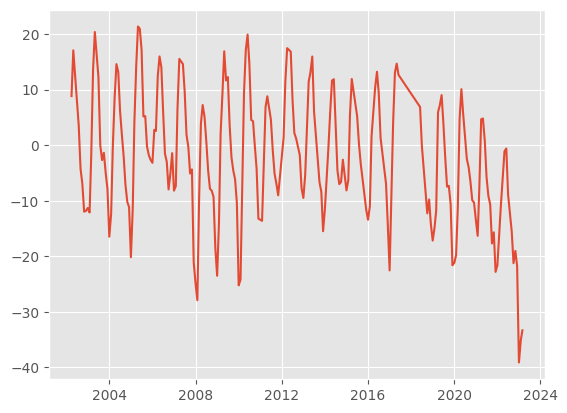

In [75]:
import matplotlib.pyplot as plt

plt.plot('time', 'gw_estimate', data=gw_crb)
plt.show()

Now, we can move on to the next notebook where we can visualize this output in more depth. 

In [76]:
gw_final_df.reset_index(drop=True)

,time,lon,lat,lwe_thickness,SWE_inst,SoilMoi0_10cm_inst,SoilMoi10_40cm_inst,SoilMoi40_100cm_inst,SoilMoi100_200cm_inst,lon/lat,lwe_mean,swe_mean,soil_mean,d_SWE_inst,d_SoilMoi0_10cm_inst,d_tws,d_SWE_inst_meters,d_SoilMoi0_10cm_inst_meters,lwe,gw_estimate
0,2002-04-01,-107.875,36.125,1.351319,0.000125,16.043537,58.864773,123.722649,215.249268,36.125-107.875,0.210354,0.650040,21.524553,-0.649915,-5.481016,1.140966,-0.064992,-0.548102,0.013513,7.482251
1,2002-05-01,-107.875,36.125,12.154783,0.000000,12.051734,56.472919,118.800224,213.050522,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,-9.472819,11.944430,-0.065004,-0.947282,0.121548,22.277643
2,2002-08-01,-107.875,36.125,-17.411682,0.000000,17.868298,58.142830,113.399727,206.577927,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,-3.656256,-17.622036,-0.065004,-0.365626,-0.174117,-13.105386
3,2002-09-01,-107.875,36.125,-16.526976,0.000000,22.623304,68.452309,124.612617,206.479935,36.125-107.875,0.210354,0.650040,21.524553,-0.650040,1.098751,-16.737329,-0.065004,0.109875,-0.165270,-16.975687
4,2002-10-01,-107.875,36.125,-24.470710,0.112339,22.559456,68.264977,132.215912,211.294083,36.125-107.875,0.210354,0.650040,21.524553,-0.537702,1.034903,-24.681063,-0.053770,0.103490,-0.244707,-24.967911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254315,2022-12-01,-117.125,33.875,-19.125283,0.000282,16.864626,42.674332,55.696980,177.346100,33.875-117.125,0.001223,0.000352,12.587101,-0.000070,4.277525,-19.126506,-0.000007,0.427752,-0.191253,-23.402738
254316,2023-01-01,-117.125,33.875,-17.598774,0.000000,23.574604,69.072105,99.626030,178.505325,33.875-117.125,0.001223,0.000352,12.587101,-0.000352,10.987503,-17.599996,-0.000035,1.098750,-0.175988,-28.585925
254317,2023-02-01,-117.125,33.875,-15.706288,0.000402,22.380682,66.381210,125.905861,187.203217,33.875-117.125,0.001223,0.000352,12.587101,0.000050,9.793581,-15.707511,0.000005,0.979358,-0.157063,-25.499919
254318,2023-03-01,-117.125,33.875,-15.985284,0.000000,23.861725,72.373627,134.795059,196.240570,33.875-117.125,0.001223,0.000352,12.587101,-0.000352,11.274624,-15.986506,-0.000035,1.127462,-0.159853,-27.259556


In [77]:
import csv

gw_final_df.to_csv("../notebooks-and-markdowns/gw_final_df.csv", index=False)



## Citations

(Sharma D, Patnaik S, Biswal B, Reager JT. Characterization of Basin-Scale Dynamic Storage–Discharge Relationship Using Daily GRACE Based Storage Anomaly Data. Geosciences. 2020; 10(10):404. https://doi.org/10.3390/geosciences10100404). 

Merging shapefiles in ArcGIS. (n.d.). Retrieved July 24, 2023, from https://www.restore.ac.uk/geo-refer/91010mwors01y00000000.php


